In [ ]:
# here I want to see if it's possible to keep the
# number of EIM bases fixed
# but then sample the coefficients with more points
# during the fitting process

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [2]:
import tqdm 

In [90]:
import os

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

from scrinet.interfaces import lalutils

In [4]:
from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate
from scrinet.fits import nn

# Data acquisition 

We need a function that we can call to
generate data in a uniform way.We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [5]:
def gen_1d_massratio_data(q_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4_opt, inclination=0,
                          t_min=-10000, t_max=100, npts=5000
                         ):

    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        # interpolate around peak
#         max_amp_idx = amp.argmax()
#         tpeak = t[max_amp_idx]
#         t_fine = np.linspace(tpeak-10, tpeak+10,1000)
#         amp_fine = iamp(t_fine)
#         tpeak = t_fine[amp_fine.argmax()]
        
        
#         iamp = IUS(t-tpeak, amp)
#         iphase = IUS(t-tpeak, phase)
        amp = iamp(new_times)
        phase = iphase(new_times)

        
        tshift = lalutils.peak_align_shift(new_times, amp)
        amp = lalutils.peak_align_interp(new_times, amp, tshift)
        phase = lalutils.peak_align_interp(new_times, phase, tshift)

        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

# dev sur class 

In [96]:
class Surrogate(object):
    def __init__(self, integration, basis_method='eim', output_dir=""):
        """
        basis_method {str}: default 'eim'. Can also be 'rb'
            Choose which method to use as the basis.
            Either 'eim' which is the empirical interpolation method
            or 'rb' which is the reduced basis method
        output_dir {str}: default ""
            directory where things will be saved.
            will default to current directory
        """
        self.integration = integration
        self.basis_method = basis_method
        self.output_dir = output_dir
        if self.output_dir:
            os.makedirs(f"{self.output_dir}", exist_ok=True)
        else:
            self.output_dir = "./"

        self.grb = greedyrb.GreedyReducedBasis(
            integration=self.integration
        )

        pass

    def build_seed_basis(self, ts, ts_coords):
        print("building seed basis")
        self.grb.build_seed_basis(ts=ts, ts_coords=ts_coords)

    def run_greedy_sweep(self, ts, ts_coords, greedy_tol=1e-4, verbose=False):
        self.grb.greedy_sweep(ts, ts_coords, greedy_tol=greedy_tol)

    def build_eim(self, ts):
        self.grb.build_eim(ts)

    def get_basis(self):
        if self.basis_method == 'eim':
            try:
                basis = self.grb.eim.B
            except AttributeError as error:
                print("Can't find EIM basis. Perhaps you forgot to construct the EIM with self.grb.build_eim()")
                raise
        elif self.basis_method == 'rb':
            basis = self.grb.basis
        return basis

    def compute_projection_coefficients(self, ts):
        """
        given an input training set (ts) compute projection
        coefficients using the current self.basis_method
        """
        
        if self.basis_method == 'eim':
            try:
                idxs = self.grb.eim.indices
            except AttributeError as error:
                print("Can't find EIM indicies. Perhaps you forgot to construct the EIM with self.grb.build_eim()")
                raise
            alpha = np.transpose(ts)[idxs].T
        elif self.basis_method == 'rb':
            alpha = self.grb.compute_projection_coefficients_array(self.grb.basis, ts)
            
        return alpha
    
    def save_basis(self, filename):
        """
        saves the basis as a "filename.npy" file
        """
        basis = self.get_basis()
        np.save(os.path.join(self.output_dir, filename), basis)

    def fit_eim(self, X, y, maxdegs=None, max_deg_total=None, method='lr', epochs=1000, scaleX=False, scaleY=False, verbose=True, nn_outname="best.h5", validation_data=None, nn_verbose=0, batch_size=None, outname_prefix=""):
        """
        X: domain.shape = (N, M): N = number of greedy points, M = dimensionality.
            e.g., if non-spinning then M=1
        y: range.shape = (P, N) where P is the number of outputs
            EIM data or RB data
        method: default = 'lr' == linear polynomial basis regression
        epochs, scaleX, scaleY, nn_outname: only for method='nn'
        nn_outname: name of output h5 file. '.h5' get appended automatically
        """
        self.method = method
        self.scaleX = scaleX
        self.scaleY = scaleY

        if self.method == 'lr':
            if maxdegs is None:
                raise ValueError("maxdegs is None")
            if max_deg_total is None:
                raise ValueError("max_deg_total is None")


        if X.shape[1] > 1 and method == 'gpr':
            raise NotImplementedError(f"Dimension is: {X.shape[0]}. GPR only implemented for 1D at the moment.")


        fits = []

        if self.method == 'nn':
            fit = nn.RegressionANN()
            if verbose:
                print("\n====\ntraining NN\n====\n")

            nn_outname = os.path.join(self.output_dir, nn_outname)
            self.history = fit.fit(
                X,
                y.T,
                input_dim=X.shape[1],
                noutput=y.shape[0],
                epochs=epochs,
                validation_data=validation_data,
                outname=nn_outname,
                scaleX=self.scaleX,
                scaleY=self.scaleY,
                verbose=nn_verbose,
                batch_size=batch_size
                )

            fit.load_model(nn_outname)
            fits.append(fit)

        if verbose and self.method == 'nn':
            self.plot_history(outname=outname_prefix)

        for i, ydata in enumerate(y):

            if self.method == 'lr':
                max_degs = poly.generate_degrees(
                    maxdegs=maxdegs, max_deg_total=max_deg_total)
                fit, _ = poly.findpolyfit(
                    X,
                    ydata,
                    max_degs=max_degs,
                    output_best=True,
                    verbose=False
                    )
                fits.append(fit)
            elif self.method == 'gpr':
#                 solver in [george.HODLRSolver, george.BasicSolver]
                solver = george.BasicSolver
                jitter = 1e-4
                yerr = np.zeros(ydata.shape) + jitter
                fit = gprfit.GPRFit(X, ydata, yerr=yerr)
                kernel = np.var(ydata) * kernels.ExpSquaredKernel(0.5, ndim=1, axes=0)
                fit.setup_kernel(kernel)

                fit.fit(solver=solver)
                fit.opt()
                fits.append(fit)

            if verbose:
                self.plot_fit(X, ydata, fit, i, validation_data=validation_data, outname_prefix=outname_prefix)

        self.fits = fits

    def plot_history(self, outname=None):
        """
        outname {str}, default is None
            shoule be something like 'loss.png'
        """
        import matplotlib
        import matplotlib.pyplot as plt

        plt.figure()
        plt.plot(self.history.history['loss'], label='training loss')
        if 'val_loss' in self.history.history.keys():
            plt.plot(self.history.history['val_loss'], label='validation loss')
        plt.yscale('log')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.tight_layout()
        if outname:
            outname = os.path.join(self.output_dir, f"{outname}_loss.png")
            plt.savefig(outname)
        else:
            plt.show()
        plt.close()

    def plot_fit(self, X, ydata, fit, basis_idx, validation_data=None, outname_prefix=None):
        """
        outname_prefix {str}, default is None
            final outname will be f"{outname_prefix}_{basis_idx}.png"
        basis_idx {int}
            basis number to plot
        validation_data {2 tuple}, default is None
            (Xval, yval)
        """
        import matplotlib
        import matplotlib.pyplot as plt

        if self.method == 'lr':
            yhat = fit.predict(X)
        elif self.method == 'gpr':
            # haven't implemented uncertainty
            yhat, _ = fit.predict(X)
        elif self.method == 'nn':
            yhat = fit.predict(X).T[basis_idx]

        if X.shape[1] == 1:
            xhat = np.linspace(
                X.min(),
                X.max(),
                1000)
            if self.method == 'lr':
                yhat_cont  = fit.predict(xhat.reshape(-1,1))
                xhat = np.exp(xhat)
                x2 = np.exp(X.ravel())
            elif self.method == 'gpr':
                # haven't implemented uncertainty
                yhat_cont, _  = fit.predict(xhat.reshape(-1,1))
                xhat = np.exp(xhat)
                x2 = np.exp(X.ravel())
            if self.method == 'nn':
                yhat_cont = fit.predict(xhat.reshape(-1,1)).T[basis_idx]
                xhat = np.exp(xhat)
                x2 = np.exp(X.ravel())
            plt.figure()
            plt.title(f"basis number = {basis_idx}")

            if validation_data:
                xval = np.exp(validation_data[0])
                yval = validation_data[1][:,basis_idx]
                plt.scatter(xval, yval, label='validation')

            plt.plot(xhat, yhat_cont, label='extrap', c='C1')
            plt.scatter(x2, ydata, label='data', s=50, c='r', lw=2)
            plt.scatter(x2, yhat, label='fit', marker='x', s=100, lw=2, c='k')
            plt.legend()
            plt.tight_layout()
            if outname_prefix:
                outname = os.path.join(self.output_dir, f"{outname_prefix}_{basis_idx}.png")
                plt.savefig(outname)
            else:
                plt.show()
            plt.close()
        else:
            plt.figure()
            plt.title(f"basis number = {basis_idx}")
            range_x = range(len(yhat))
            plt.scatter(range_x, ydata, label='data', s=50, c='r', lw=2)
            plt.scatter(range_x, yhat, label='fit', marker='x', s=100, lw=2, c='k')
            plt.legend()
            plt.tight_layout()
            if outname_prefix:
                outname = os.path.join(self.output_dir, f"{outname_prefix}_{basis_idx}.png")
                plt.savefig(outname)
            else:
                plt.show()
            plt.close()

    def predict(self, coords, log_index=0):
        """
        coords.shape = (1, M), M=dimension
        log_index: take the log of the log_index'th component.
            by default this is the 0th index.
            Use `log_index=None` to not modify the `coords`.
        """
        coords = np.array(coords)

        assert len(coords.shape) > 1, f"expected shape is (1, M) but got {coords.shape}"

        if log_index != None:
            coords[0,log_index] = np.log(coords[0,log_index])

        alpha = np.zeros(len(self.fits))

        if self.method == 'lr':
            for i, fit in enumerate(self.fits):
                alpha[i] = fit.predict(coords)
        elif self.method == 'gpr':
            for i, fit in enumerate(self.fits):
                # haven't implemented uncertainty
                alpha[i], _ = fit.predict(coords)
        elif self.method == 'nn':
            alpha = self.fits[0].predict(coords)[0]

        if self.basis_method == 'eim':
            basis = self.grb.eim.B
        elif self.basis_method == 'rb':
            basis = self.grb.basis

        return np.dot(alpha, basis)

    def validate_surrogate(self, vts, vts_coords, x=None, a=None, b=None):
        """
        vts: validation training set
            vts.shape() = (N, P)
                N = number of entries
                P = number of points e.g. length of time or frequency series
        vts_coords: validation training set coordinates / parameters
            vts_coords.shape() = (N, M).
                N = number of entries
                M = dimensionality
        x: np.ndarray of shape (P,). Default: None
        a, b: float/int. the start and end values of x for integration.
            Default: None
        """
        if self.method in ['lr', 'gpr', 'nn']:
            log_index = 0
        # elif self.method == 'nn':
        #     log_index = None

        if x is not None:
            if a is None:
                a = x[0]
            if b is None:
                b = x[-1]
            mask = (x>=a) & (x<=b)
            x = x[mask]
            integration = greedyrb.Riemann([a,b], len(x))
        else:
            integration = self.grb.integration
            # mask that is all True
            mask = np.ones(vts[0].shape).astype(np.bool)

        model_errors = np.zeros(len(vts))
        for i in range(len(vts)):
            yhat = self.predict([vts_coords[i]], log_index=log_index)[mask]
            y = vts[i][mask]
            # error = self.grb.integration.norm(y-yhat)**2
            error = integration.norm(y-yhat)**2
            model_errors[i] = error

        worst_error_index = np.argmax(model_errors)
        worst_case = vts_coords[worst_error_index]

        return model_errors, worst_case, worst_error_index


In [97]:
amp_or_phase = "phase"

mtotal=60
qmin=1
qmax=20
initial_qnum=2

qnpts=100

qnpts_validation=100

greedy_tol=1e-6

seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(qmin, qmax, initial_qnum), mtotal)
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

# sur = surrogate.Surrogate(integration, basis_method='rb')
sur = Surrogate(integration, basis_method='eim')



if amp_or_phase == "amp":
    seed_ts = seed_ts_amp
elif amp_or_phase == "phase":
    seed_ts = seed_ts_phase

sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)

# check seed basis and add points
_, ts_amp, ts_phase, ts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, qnpts), mtotal)

if amp_or_phase == "amp":
    ts = ts_amp
elif amp_or_phase == "phase":
    ts = ts_phase
    
sur.run_greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=greedy_tol)

building seed basis
step = 0, error = 1892.13739486688
step = 1, error = 2.8230244660228085
step = 2, error = 0.39936870028194416
step = 3, error = 0.0035520948830865757
step = 4, error = 0.00039928860774937527
step = 5, error = 8.99669326392115e-05
step = 6, error = 4.210846210496868e-05
step = 7, error = 6.412103180998632e-06
step = 8, error = 1.313399588783039e-06
tolerance reached. exiting


In [98]:
# get basis and projection coefficients of reduced basis
_, ts_amp, ts_phase, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), mtotal)
if amp_or_phase == "amp":
    ts = ts_amp
elif amp_or_phase == "phase":
    ts = ts_phase 

Text(0, 0.5, 'mass-ratio')

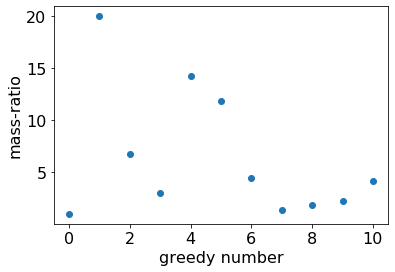

In [99]:
plt.figure()
plt.scatter(range(sur.grb.nbasis), sur.grb.greedy_points[:,0])
plt.xlabel("greedy number")
plt.ylabel("mass-ratio")

In [100]:
# make EIM from greedy points
sur.build_eim(ts)

In [101]:
basis = sur.get_basis()

In [102]:
basis.shape

(11, 5000)

Text(0.5, 1.0, 'initial basis with 11 elements')

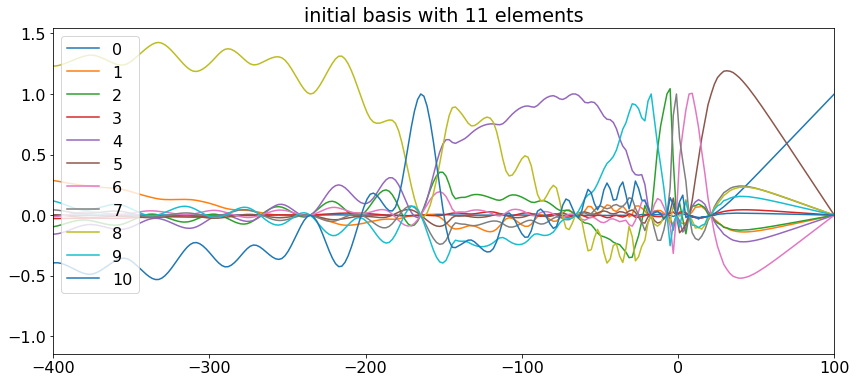

In [103]:
plt.figure(figsize=(14,6))
for i in range(sur.grb.nbasis):
    plt.plot(seed_x, basis[i], label=f'{i}')
plt.legend(loc='upper left')
plt.xlim(-400,100)
# plt.xlim(-100,100)
plt.title(f"initial basis with {sur.grb.nbasis} elements")

In [104]:
# compute validation points
# check seed basis and add points
_, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, qnpts_validation), mtotal)
# _, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.linspace(qmin, qmax, qnpts_validation), mtotal)

if amp_or_phase == "amp":
    vts = vts_amp
elif amp_or_phase == "phase":
    vts = vts_phase
    

In [105]:
sur.grb.eim.indices

array([4999, 4521, 4946, 2871, 4917, 4960, 4953, 4949, 4833, 4941, 4868])

In [106]:
alpha_val = sur.compute_projection_coefficients(vts)

In [107]:
alpha_val.shape

(100, 11)

In [108]:
sur.grb.eim.data.shape

(11, 11)

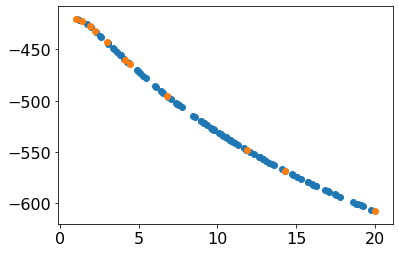

In [110]:
plt.figure()
plt.scatter(vts_coords[:,0], alpha_val[:,0])
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.eim.data[0])

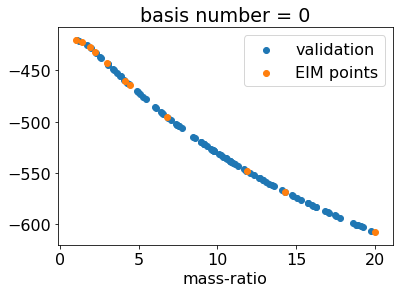

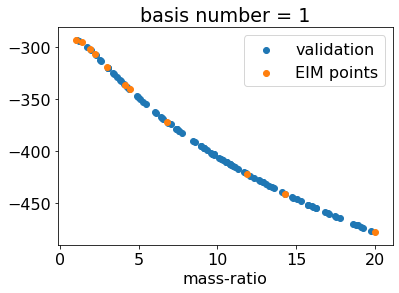

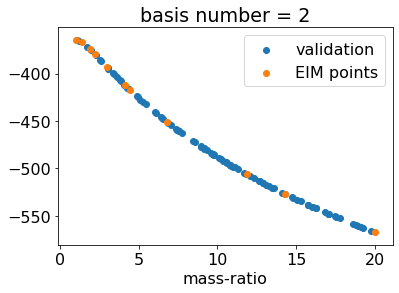

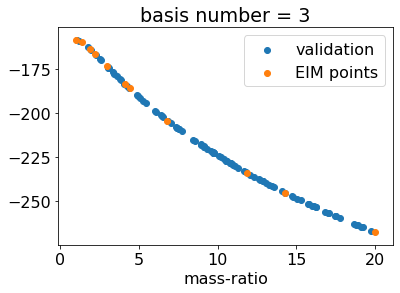

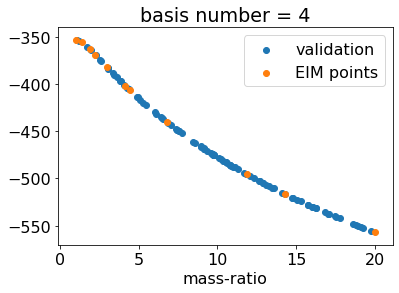

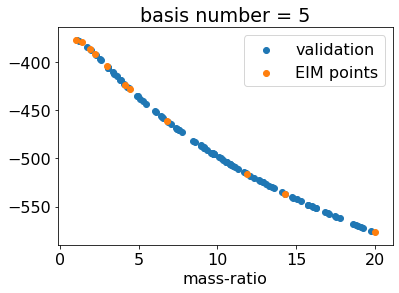

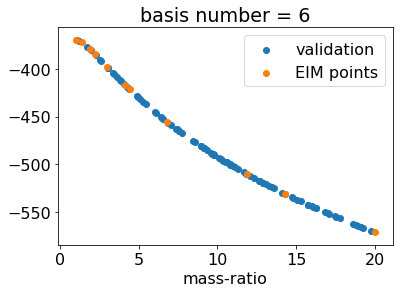

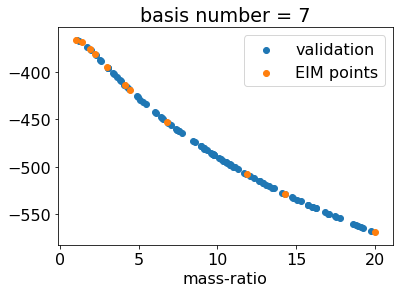

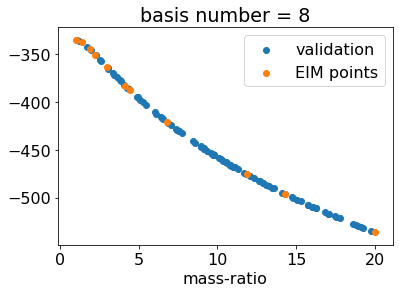

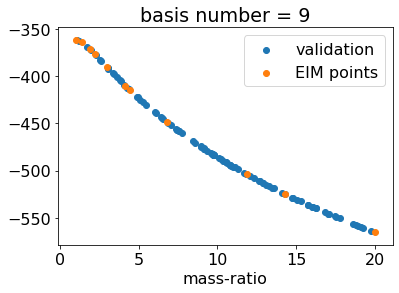

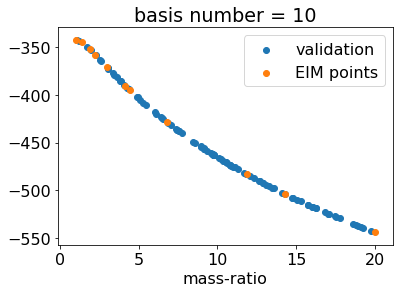

In [111]:
for i in range(sur.grb.nbasis):
    plt.figure()
    plt.scatter(vts_coords[:,0], alpha_val[:,i], label='validation')
    plt.scatter(sur.grb.greedy_points[:,0], sur.grb.eim.data[i], label='EIM points')
    plt.legend()
    plt.xlabel("mass-ratio")
    plt.title(f'basis number = {i}')
    plt.show()
    plt.close()

# take the projection coefficients and try and fit them with NN

In [112]:
y.shape

(12, 12)

In [113]:
X.shape

(12, 1)

In [114]:
Xval.shape

(100, 1)

In [115]:
alpha_val.shape

(100, 11)

In [144]:
sur.grb.eim.data.shape

(11, 11)


====
training NN
====



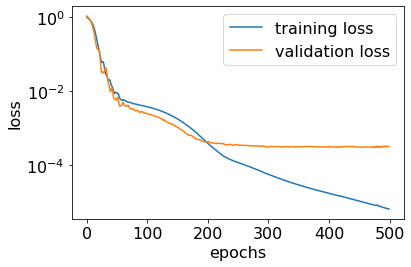

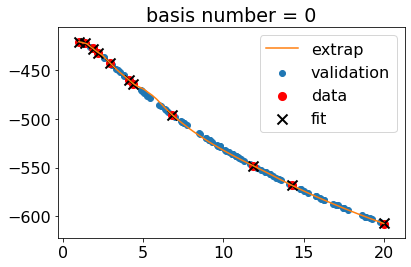

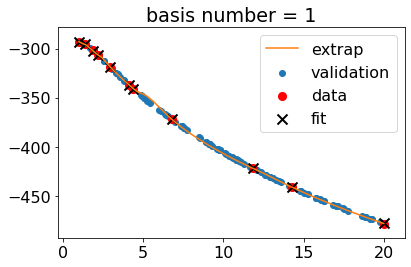

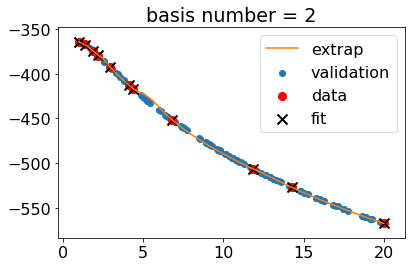

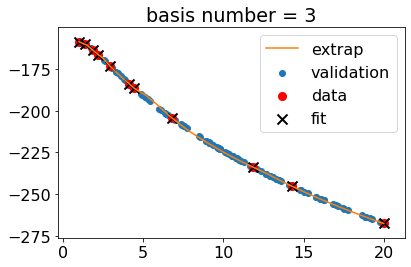

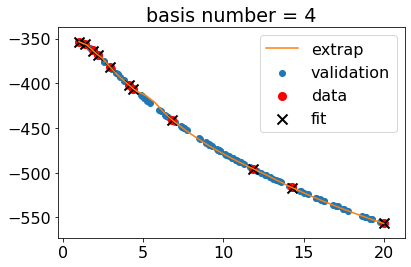

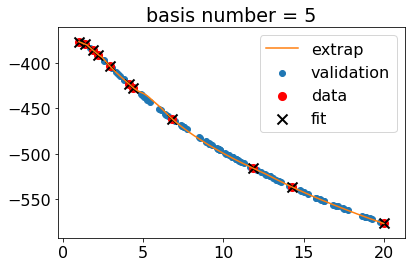

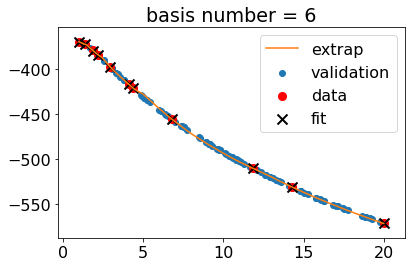

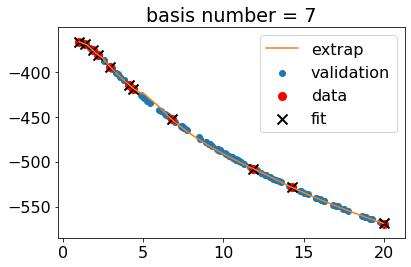

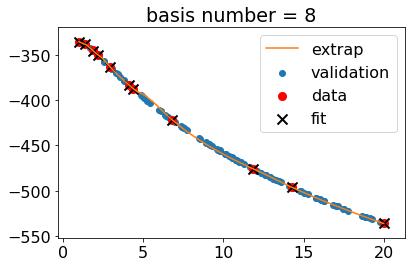

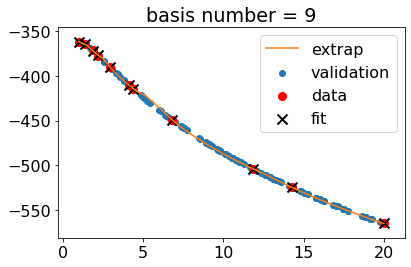

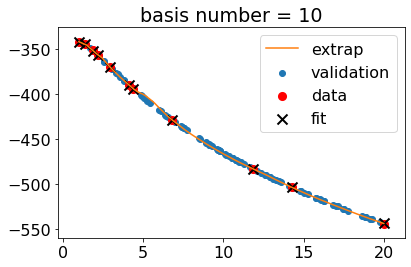

In [135]:
epochs=500
scaleX=True
scaleY=True
X = sur.grb.greedy_points.copy()
X[:,0] = np.log(X[:,0])
y = sur.grb.eim.data.T


Xval = vts_coords.copy()
Xval[:,0] = np.log(Xval[:,0])

validation_data=(Xval, alpha_val)

sur.fit_eim(X, y.T, method='nn', maxdegs=[4], max_deg_total=4, epochs=epochs, scaleX=scaleX, scaleY=scaleY, verbose=True, nn_outname=amp_or_phase + "_best.h5", validation_data=validation_data)

In [136]:
pred1 = sur.predict([vts_coords[0]])

In [137]:
pred1

array([ 0.00000000e+00, -7.90314200e-02, -1.58067471e-01, ...,
       -5.85736197e+02, -5.86549373e+02, -5.87362549e+02])

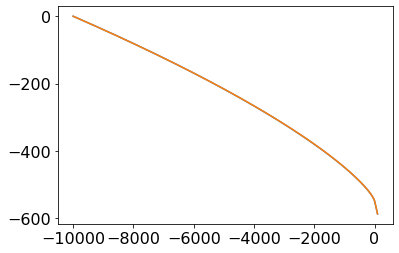

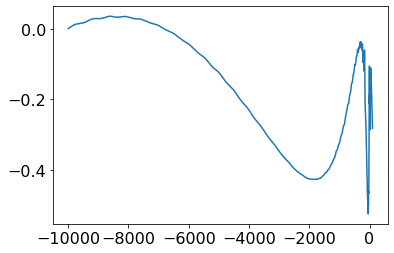

In [138]:
plt.figure()
plt.plot(x, pred1)
plt.plot(x, vts[0])

plt.figure()
plt.plot(x, pred1-vts[0])

In [139]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
worst_error = model_errors[worst_error_index]
print(f"worst error = {worst_error}")
print(f"worst case = {worst_case}")

worst error = 55702.064941530945
worst case = [5.43229989]


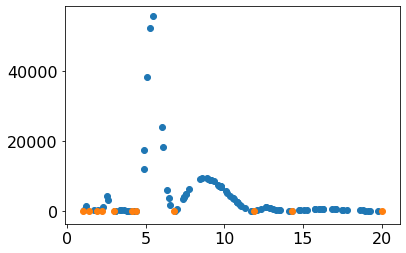

In [140]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

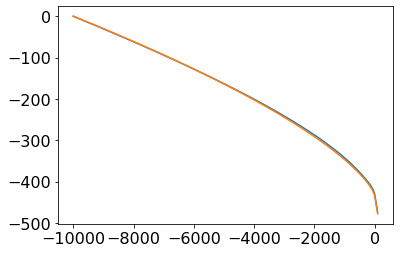

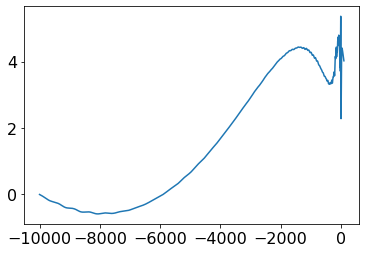

In [141]:
worst_pred = sur.predict([worst_case])

plt.figure()
plt.plot(x, worst_pred)
plt.plot(x, vts[worst_error_index])
plt.show()
plt.close()

plt.figure()
plt.plot(x, worst_pred-vts[worst_error_index])
plt.show()
plt.close()

# add many points to training set

In [230]:
# compute validation points
# check seed basis and add points
# _, ts_amp, ts_phase, ext_ts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, 1000), mtotal)
# _, ts_amp, ts_phase, ext_ts_coords = gen_1d_massratio_data(np.linspace(qmin, qmax, 1000), mtotal)

lowq = np.linspace(1, 5, 500, endpoint=False)
middleq = np.linspace(5, 15, 500, endpoint=False)
highq = np.linspace(15, qmax, 500)
sample_q = np.concatenate((lowq, middleq, highq))

_, ts_amp, ts_phase, ext_ts_coords = gen_1d_massratio_data(sample_q, mtotal)

if amp_or_phase == "amp":
    ext_ts = ts_amp
elif amp_or_phase == "phase":
    ext_ts = ts_phase


In [231]:
ext_alpha = sur.compute_projection_coefficients(ext_ts)

In [232]:
Xnew = ext_ts_coords.copy()
Xnew[:,0] = np.log(Xnew[:,0])

In [233]:
epochs=1500
scaleX=True
scaleY=True

Xfit = np.row_stack((X, Xnew))
yfit = np.row_stack((y, ext_alpha))



In [234]:
yfit.shape

(1511, 11)

In [235]:
Xfit.shape

(1511, 1)

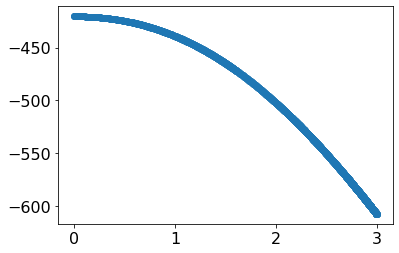

In [236]:
plt.figure()
plt.scatter(Xfit[:,0], yfit[:,0])

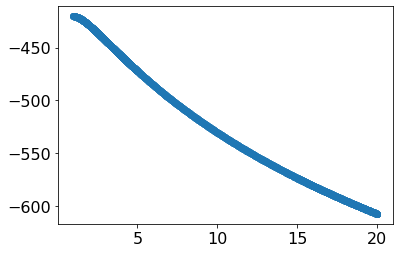

In [237]:
plt.figure()
plt.scatter(np.exp(Xfit[:,0]), yfit[:,0])

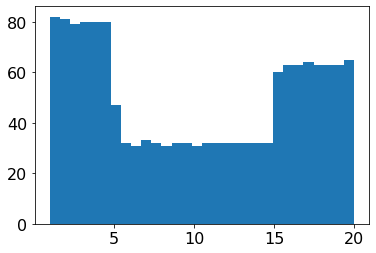

In [238]:
plt.figure()
plt.hist(np.exp(Xfit[:,0]), bins=30);

In [44]:
# compute validation points
# check seed basis and add points
_, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, 1000), mtotal)

if amp_or_phase == "amp":
    vts = vts_amp
elif amp_or_phase == "phase":
    vts = vts_phase
    
alpha_val = sur.compute_projection_coefficients(vts)


====
training NN
====



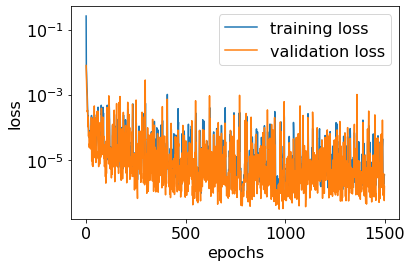

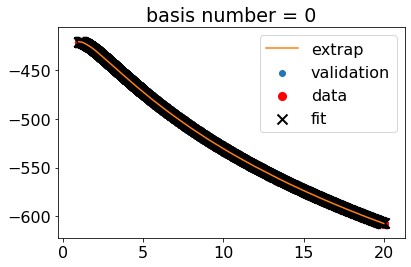

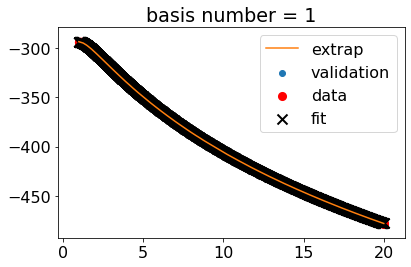

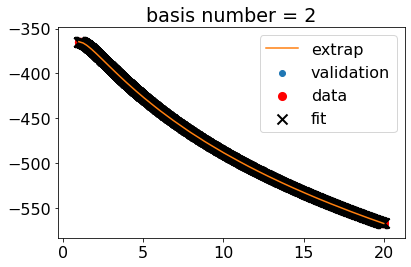

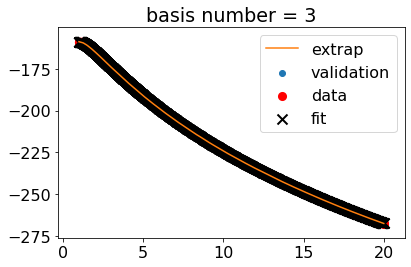

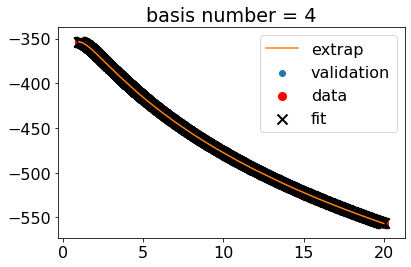

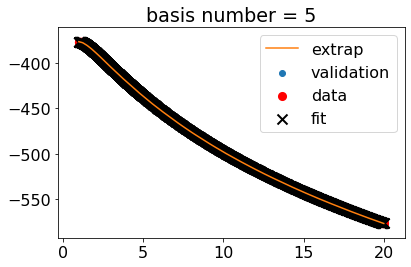

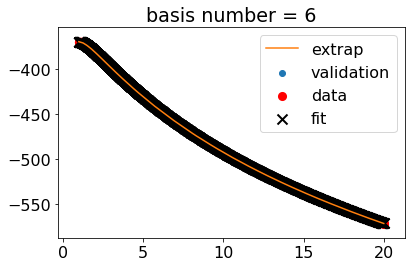

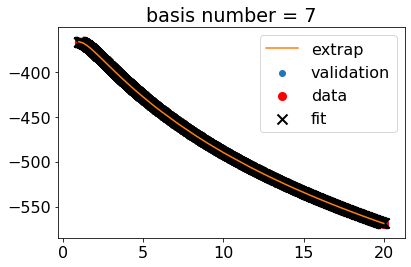

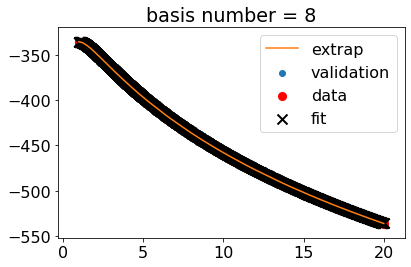

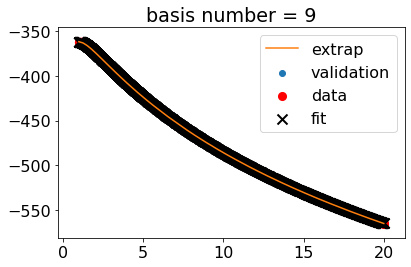

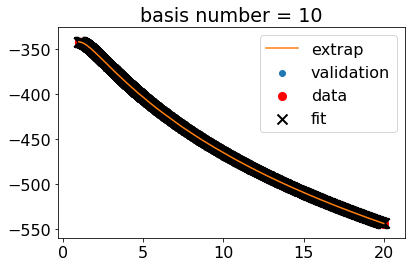

In [239]:
Xval = vts_coords.copy()
Xval[:,0] = np.log(Xval[:,0])

validation_data=(Xval, alpha_val)

sur.fit_eim(Xfit, yfit.T, method='nn', epochs=epochs, scaleX=scaleX, scaleY=scaleY, verbose=True, nn_outname=amp_or_phase + "_best.h5", validation_data=validation_data, nn_verbose=0)

In [240]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
worst_error = model_errors[worst_error_index]
print(f"worst error = {worst_error}")
print(f"worst case = {worst_case}")

worst error = 95.00693901638635
worst case = [1.07683181]


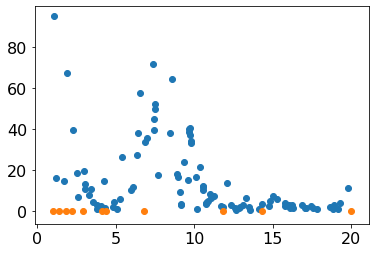

In [241]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

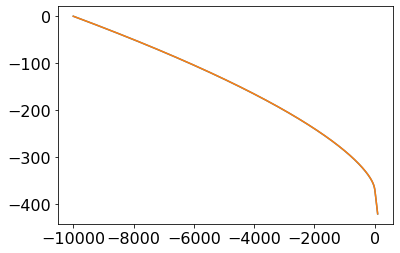

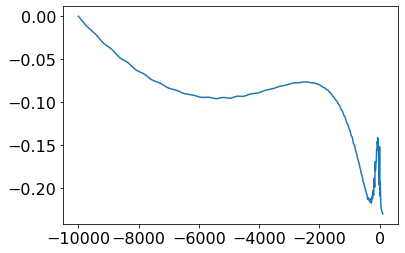

In [242]:
worst_pred = sur.predict([worst_case])

plt.figure()
plt.plot(x, worst_pred)
plt.plot(x, vts[worst_error_index])
plt.show()
plt.close()

plt.figure()
plt.plot(x, worst_pred-vts[worst_error_index])
plt.show()
plt.close()